<a href="https://colab.research.google.com/github/DuplamenteH/Ds/blob/master/detec%C3%A7%C3%A3o_de_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [ ]:
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools
from datetime import timedelta
from IPython.display import display


path = '/content/drive/My Drive/DadosAlura/modeles preditivos risco-credito/'

In [ ]:
#path = '/content/drive/My Drive/DadosAlura/modeles preditivos risco-credito/'
fraude_df = pd.read_csv(path+'Fraud_Data.csv', header=0)
isp_df = pd.read_csv(path+'IpAddress_to_Country.csv', header=0)


In [ ]:
fraude_df.info()

### Verificando valores nulos

In [ ]:
for col in fraude_df.columns:
    print("# de valores nulos em {}: {}".format(col, fraude_df[col].isnull().sum()))

In [ ]:
for col in isp_df.columns:
    print("# de valores nulos em {}: {}".format(col, isp_df[col].isnull().sum()))

## Estatística descritivas

In [ ]:
fraude_df.describe()

In [ ]:
for col in isp_df.columns:
    print("{} : {}".format(col, isp_df[col].dtype))

In [ ]:
ip_floats = isp_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print("Número de limites inferiores de endereço IP com decimal não-zero: {}".format(ip_floats))

In [ ]:
isp_df.limite_inferior_ip = isp_df.limite_inferior_ip.astype(int)

In [ ]:
display(isp_df[isp_df.limite_inferior_ip == isp_df.limite_inferior_ip.max()])
display(isp_df[isp_df.limite_superior_ip == isp_df.limite_superior_ip.max()])

In [ ]:
'''
    O metódo abaixo faz a relação entre as duas base de dados.'
    Então faremos uma contagem associada a cada um dos erros e saberemos quantos endereços de IP possuem um país exclusivo atribuído a estes. 
    Desta forma, poderemos saber quantos países geraram fraudes e quantas fraudes vieram de cada localidade.
'''


def isp_counts(isp):
    pais = isp_df[(isp_df.limite_inferior_ip <= isp) & (isp_df.limite_superior_ip >= isp)].pais
    if pais.shape[0] == 1:
        return print("Único")
    elif pais.shape[0] > 1:
        return print("Vários países")
    elif pais.shape[0] == 0:
        if isp > isp_df.limite_superior_ip.max():
            return print("Muito grande")
        elif isp < isp_df.limite_inferior_ip.min():
            return print("Muito pequeno")
        else:
            return print("Faltando")

ip_counts = fraude_df.ip.apply(isp_counts)
ip_counts.value_counts()

In [ ]:
'''
    IP para pais.
    olhando na base de dados onde tem o nome do pais de acordo com ip informado.
    
'''

def ip_to_pais(ip):
    tmp = isp_df[(isp_df.limite_inferior_ip <= ip) & (isp_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return print("Faltando")
    elif tmp.shape[0] > 1:
        return print("Erro")


In [ ]:
#Executando o metodo e criando a coluna pais no dataframe fraude_df
fraude_df["pais"] = fraude_df.ip.apply(ip_to_pais)


In [ ]:
#Resultado df
fraude_df.head()

In [ ]:
#Salvando Dataframe com pais .
fraude_df.to_csv(path+"Dados_fraude_com_pais.csv", index=False)

## Análise Exploratória do Dados.

In [ ]:
df_fraude = pd.read_csv(path+"Dados_fraude_com_pais.csv", header=0)

In [ ]:
font = {
    'fontsize': 15
}

O gráfico acima indica uma maior quantidades de homens como cliente da empresa, como por consequencia uma maior quantidade de fraude entre os homens.

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x='genero', hue = 'fraude' , data=df_fraude)
plt.xlabel("Generos", fontdict= font)
plt.ylabel("Casos", fontdict= font)

sem informações consistentes <br/>
             ↓

In [ ]:
plt.figure(figsize=(15,10))
sns.catplot(x='fraude', y='valor', data=df_fraude,kind='point')
plt.xlabel("Não fraude (0) / Fraude(1)", fontdict=font)
plt.ylabel("Valor de compra ", fontdict=font)

Não conseguimos tirar informações uteis pois o aumento de idade é muito sutil<br/>
             ↓


In [ ]:
plt.figure(figsize=(15,10))
sns.catplot(x='fraude', y='idade', data=df_fraude,kind='point')
plt.xlabel("Não fraude (0) / Fraude(1)", fontdict=font)
plt.ylabel("Valor de compra ", fontdict=font)

Não parece de forma geral que exista uma fonte de marketing mais ligada as fraudes <br/> , porém existem menos fontes diretas ligadas as fraudes, mas em relação as outras fontes direta é menor que as outras.<br/>
Os mecanimos de buscas e anúncio na web, por outro lado trazem mais ações fraudolentas, talvez para a empresa em questão seja mais vantajoso fazer operações de marketing fora deste 2 setores.

In [ ]:
plt.figure(figsize=(15,10))
sns.catplot(x='fonte',hue='fraude' , data=df_fraude,kind='count')
plt.xlabel("Não fraude (0) / Fraude(1)", fontdict=font)
plt.ylabel("Valor de compra ", fontdict=font)

In [ ]:
soma_fraude = df_fraude[df_fraude['fraude']==1]['fraude'].groupby(df_fraude.pais).sum()
soma_fraude = soma_fraude.to_frame().reset_index()

soma_nfraude = df_fraude[df_fraude['fraude']==0]['fraude'].groupby(df_fraude.pais).sum()
soma_nfraude = soma_nfraude.to_frame().reset_index()

In [ ]:
f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=soma_fraude,
            label="Total", color="b")
plt.xlabel("Contagem",fontsize=15)
plt.ylabel("Países",fontsize=15)

Agrupando algumas informações abaixo.

In [ ]:
temp_df = pd.DataFrame(columns=("Fraude","id_por_dispositivo","id_por_ip"))
temp_df['Fraude'] = df_fraude['fraude']

userid_count = df_fraude.groupby('id_dispositivo').id.count()
temp_df['id_por_dispositivo'] = df_fraude.id_dispositivo.apply(lambda x : userid_count[x])

userid_count2 = df_fraude.groupby('ip').id.count()
temp_df['id_por_ip'] = df_fraude.id_dispositivo.apply(lambda x : userid_count[x])



In [ ]:
sns.factorplot(x="Fraude", y="id_por_dispositivo", data=temp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por dispositivo", fontsize=15)

sns.factorplot(x="Fraude", y="id_por_ip", data=temp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por endereço IP", fontsize=15)

Vemos que  vários IDs de usuários associados a um ID de dispositivo único ou a um endereço IP nos fornecem um grande indicador de comportamentos fraudulentos.

Essa observação faz sentido, pois se tivermos uma só pessoa realizando compras no E-commerce, teremos apenas um ID e um dispositivo, ou um ID e um endereço de IP, ou seja, caso haja um ID de usuário associado a vários dispositivos ou endereços de IP, é possível entender que há diversas pessoas ou robôs manipulando a conta.<br/>
<br/>
<br/>

Analisando os gráficos, veremos uma média de 7 IDs por dispositivo ou endereço de IP. Pode ser que haja um mesmo computador com um IP próprio conectado em uma mesma rede que está utilizando várias contas, o que indica fraudes também.

In [ ]:
temp_df['cadastro'] = df_fraude.cadastro.apply(pd.to_datetime)
temp_df['compra'] = df_fraude.compra.apply(pd.to_datetime)
temp_df['tempo']  = (temp_df.compra - temp_df.cadastro).apply(lambda x : x.seconds)


In [ ]:
sns.factorplot(x="Fraude", y="tempo", data=temp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Tempo entre o inicio e compra (Segundos)", fontsize=15)

Em casos de não fraude o tempo é bem maior o usuario tem que entrar no site, fazer um cadastro e isso demora um certo tempo, já nos casos de fraude o tempo é quase menos da metade.

In [ ]:
temp_df.head()

In [ ]:
temp_df[temp_df["Fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Hora do dia", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

In [ ]:
temp_df[temp_df["Fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Dia da semana", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

In [ ]:
temp_df[temp_df["Fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Semana do ano", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

In [ ]:
sums_nf = df_fraude[df_fraude['fraude'] == 0]['fraude'].groupby(df_fraude.pais).count() 
sums_nf = sums_nf.to_frame().reset_index()

In [ ]:
sums_nf.head()

In [ ]:
f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=sums_nf, label="Total", color="b")
plt.xlabel("Contagem",fontdict = font)
plt.ylabel("Países",fontdict=font)

## Feature engineering

In [ ]:
userid_count3 = df_fraude.groupby("id_dispositivo").id.count()

df_fraude['id_por_dispositivo'] = df_fraude.id_dispositivo.apply(lambda x : userid_count3[x])

df_fraude.head()

In [ ]:
userid_count4 = df_fraude.groupby("ip").id.count()
df_fraude["id_por_ip"] = df_fraude.ip.apply(lambda x: userid_count4[x])

df_fraude.head()

In [ ]:
df_fraude["media_id"] = (df_fraude.id_por_dispositivo + df_fraude.id_por_ip) * 0.5

df_fraude.head()

In [ ]:
df_fraude.cadastro = df_fraude.cadastro.apply(pd.to_datetime)
df_fraude.compra = df_fraude.compra.apply(pd.to_datetime)
df_fraude["tempo"] = (df_fraude.compra - df_fraude.cadastro).apply(lambda x: x.seconds)

df_fraude.head()

In [ ]:
pais_dummies = pd.get_dummies(df_fraude.pais, prefix="pais")
df_fraude = pd.concat([df_fraude,pais_dummies], axis=1)
df_fraude.head()

In [ ]:
backup_fraude = df_fraude.copy()

In [ ]:
df_fraude.drop(["id",
            "cadastro",
            "compra",
            "id_dispositivo",
            "ip",
            "id_por_dispositivo",
            "id_por_ip",
            "pais",
            "fonte",
            "browser",
            "genero",
            "idade",
            "valor"], axis=1, inplace = True)

In [ ]:
df_fraude.head()

In [ ]:
df_fraude[df_fraude["fraude"] == 1].media_id.hist( bins=25)
plt.xlabel("Número médio de IDs", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

In [ ]:
df_fraude.tempo.hist( bins=25)
plt.xlabel("Tempo de compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

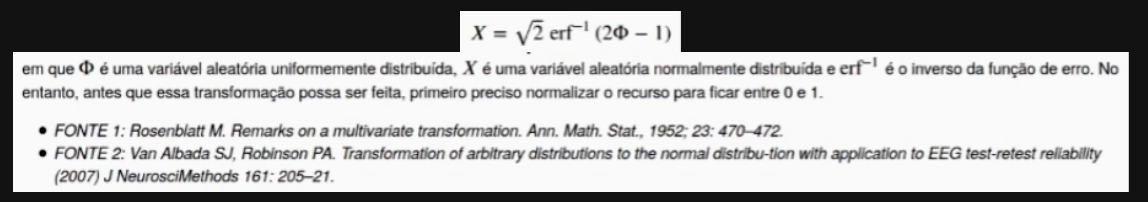

### Transformando recursos em Gaussianos

In [ ]:
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min)/(ser_max - ser_min)
    new_ser = new_ser.apply(lambda x : np.sqrt(2) * special.erfinv(2*x-1))
    return new_ser

In [ ]:
df_fraude["tempo"] = rescale_series(df_fraude.tempo)
df_fraude.tempo.hist(bins =25)
plt.xlabel("Tempo entre compra e inscrição (Segundos)", fontsize =15)
plt.ylabel("Contagem normalizda", fontsize =15)

In [ ]:
def rescale_series2(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser


oneHotencoded = [feature for feature in df_fraude.columns if 'pais' not in feature and feature != 'fraude']

for col in oneHotencoded :
    df_fraude[col] = rescale_series2(df_fraude[col])

X = df_fraude[[col for col in df_fraude.columns if col != 'fraude']]
Y = df_fraude['fraude']

In [ ]:
X.to_csv(path + 'X.csv', index= False)
Y.to_csv(path + 'Y.csv', index= False)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier



clf = ExtraTreesClassifier()
_ = clf.fit(X,Y)



features = pd.DataFrame()
features['featurea'] = X.columns
features['importancia'] = clf.feature_importances_


features[features.importancia > np.mean(features.importancia)].sort_values(by='importancia',ascending= False )

## Criando os modelos preditivos

In [ ]:
#para saber mais sobre metricas de performace vá ao livro hands-on ml 2ª edição na pagina 119 do pdf.
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
#importações

Dividimos os dados de X , Y para os atributos X_dev ,x_eval, Y_dev, y_eval usando a função train_test_split com um train size de 0.75 
<br/>
<br/>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<br/>

A Floresta de Isolamento normalmente retorna valores de 1 para casos normais e -1 para casos anômalos. Portanto, precisaremos transformar os valores de destino para corresponderem aos que iremos obter.

Começando pelo Y_dev, usaremos apply() com lambda x como 1 se o x for igual a zero, e caso contrário será -1. A mesma coisa será feita com o Y_eval de avaliação para podermos executar a célula.

In [ ]:
X_dev ,x_eval, Y_dev, y_eval = train_test_split(X,Y,train_size=0.75, random_state = 23)
Y_dev = Y_dev.apply(lambda x:1 if x==0 else -1)
y_eval = y_eval.apply(lambda x:1 if x==0 else -1)

In [ ]:
IF = IsolationForest(max_samples="auto", contamination = 0.095, random_state=1)
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF,
                param_grid,
                cv=5,
                n_jobs=10,
                scoring="f1",
                verbose=10)

_ = clf.fit(X_dev, Y_dev)

Pegando o melhor estimador do gridsearchCV<br/>
aplicando as previsões<br/>
fazendo validações <br/>
checando metricas => matriz de  confusão <br/>
fazendo plots



In [ ]:
IF_best = clf.best_estimator_

Y_predicted = IF_best.predict(x_eval)

roc_auc = roc_auc_score(y_eval, Y_predicted)


print(classification_report(y_eval,
                            Y_predicted,
                            target_names=["anomalo","normal"]))

print("Area sob a curva ROC : {:0.3f}".format(roc_auc))


IF_probs = IF_best.decision_function(x_eval)
fpr, tpr, thresold = roc_curve(y_eval, IF_probs)

plt.plot(fpr, tpr, lw =1)

plt.plot([0,1],[0,1],'--', color=(0.6,0.6,0.6),label="sorte")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel("Taxa de falso positivos", fontsize=15)
plt.ylabel("Taxa de verdadeiros positivos", fontsize=15)
plt.title("Curva ROC", fontsize=18)

plt.show()

In [ ]:
# Usando matriz de confusão
from sklearn.metrics import confusion_matrix

cnf_matrix_IF = confusion_matrix(y_eval, Y_predicted)
print(cnf_matrix_IF)

##Organizando dados de teste e validação